I need to figure out a way of translating the river mouth locations to the grid from the model. 

TOC:
1. read shapefiles (Lebreton or Meijer)
2. split Point objects.
3. bin the rivers into the coastal cells
4. Cluster the rivers in N groups
5. generate initial conditions for cluster
    - save the river coord inside the cluster
    - generate delayed realease randomized
    - save them, sneaky beasts
6. Compute priors.

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm

import random

In [7]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# def rivers_per_location(DF, loc_coords, radius, binned=False):
#     """
#     Input
#     - DF: the pandas Dataframe with data River_sources. 
#     - loc_coords: tuple with the location coordinates as in (lat, lon).
#     - radius: the radius in degrees around loc_coords.
#     Returns 
#     - the dataframe around loc_coords.
#     """
#     if binned:
#         _label = '_bin'
        
#     else:
#         _label = ''
        
#     x_col = f'X{_label}'
#     y_col = f'Y{_label}'
    
#     lat, lon = loc_coords
#     mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
#     new_DF = DF[mask]
#     return new_DF, mask

def region_filters(DF, lon_min, lon_max, lat_min, lat_max, shapefile=False):
    """
    DF is the River_sources dataframes. lat_min, lat_max, lon_min, lon_max are the domain limits.
    Returns the dataframe only for the region.
    """
    if shapefile:
        X = DF.geometry.x
        Y = DF.geometry.y
    else:
        X = DF['X']
        Y = DF['Y']
        
    mask = (X <= lon_max) & (X > lon_min) & (Y <= lat_max) & (Y > lat_min)
    
    new_DF = DF[mask]
    return new_DF
    

In [8]:
coastal_fields = xr.load_dataset('../coastal_fields.nc')

In [9]:
coast = coastal_fields.coastal.values
lats = coastal_fields.lat.values
lons = coastal_fields.lon.values

X = coastal_fields.lon_mesh
Y = coastal_fields.lat_mesh

In [10]:
iy_coast, ix_coast = np.where(coast==1)
lat_coast = lats[iy_coast]
lon_coast = lons[ix_coast]

In [11]:
def nearest_coastal_cell(latidute, longitude, coord_lat, coord_lon):    
    """
    Function to find the index of the closest point to a certain lon/lat value.
    
    latidute and longitude are the dimensinal 1D arrays of the grid, with the same length.
    coord_lat and coord_lon are the coordinates of a point.
    """
    
    distance = np.sqrt((longitude-coord_lon)**2 + (latidute-coord_lat)**2)                     
    index = distance.argmin()               
        
    return index

In [12]:
nearest_coastal_cell(lat_coast, lon_coast, -10, -30)

4777

In [13]:
South_Atlantic_region = (-70, 25, -50, -5)

# 1. Loading data from GIS shapefiles

In [14]:
def convert_geopandas2pandas(geoDF):
    '''Replaces the geometry column with a X and Y columns
    There no built-in function for this in geopandas! 
    '''
    
    L = len(geoDF)
    coord = np.zeros((L,2))
    coord[:, 0] = geoDF.geometry.x
    coord[:, 1] = geoDF.geometry.y
    aux = pd.DataFrame(coord, columns=['X','Y'])
    geoDF.drop(columns=['geometry'], inplace=True)
    geoDF = pd.concat([geoDF, aux], axis=1)
    
    return geoDF

In [15]:
path = '../data/sources/Lebreton_rivers/PlasticRiverInputs/' 
lebreton = convert_geopandas2pandas(gpd.read_file(path))

In [16]:
lebreton.head()

,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,i_high_feb,i_mid_mar,...,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,X,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21753.3,22500000.0,9.812500,37.329167
1,0.117503,0.046447,0.431570,0.008847,0.003387,0.033584,0.025464,0.010425,0.089840,0.022978,...,0.172272,0.075899,0.067729,0.176044,0.588417,0.466081,506114.0,95100000.0,9.387500,37.254167
2,0.004653,0.001518,0.021067,0.000364,0.000116,0.001692,0.000750,0.000250,0.003305,0.000905,...,0.236187,0.135462,0.101813,0.223936,0.821796,0.500808,56294.6,33500000.0,9.804167,37.237500
3,0.163098,0.065719,0.586740,0.019418,0.007780,0.070142,0.041209,0.017347,0.141035,0.030320,...,0.275328,0.182635,0.184765,0.335541,1.101117,0.927117,349409.0,99200000.0,9.229167,37.220833
4,0.038200,0.014144,0.150693,0.003528,0.001281,0.014193,0.008848,0.003407,0.033372,0.007342,...,0.200378,0.105010,0.099647,0.219543,0.728243,0.591818,199000.0,39700000.0,9.254167,37.220833


In [17]:
path = '../data/sources/Meijer2021_midpoint_emissions/' 
meijer = convert_geopandas2pandas(gpd.read_file(path))

In [18]:
meijer.head()

,dots_exten,X,Y
0,0.164904,168.797917,-46.580833
1,0.124932,168.348750,-46.447083
2,1.213370,168.337083,-46.418750
3,0.121138,168.021250,-46.357917
4,0.197533,169.811250,-46.343750


In [135]:
meijer.to_csv('../data/sources/Meijer2021_midpoint_emissions.csv')

# 2. 

In [19]:
def rivers2coastalgrid(DF, coastal_fields):
    
    N = len(DF)
    
    coast = coastal_fields.coastal.values
    lats = coastal_fields.lat.values
    lons = coastal_fields.lon.values
    iy_coast, ix_coast = np.where(coast==1)
    lat_coast = lats[iy_coast]
    lon_coast = lons[ix_coast]

    new_coordinates = np.zeros((N, 2)) 

    for i in range(N):
        x_lon = DF.iloc[i].X
        x_lat = DF.iloc[i].Y

        n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
        new_coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])
        
    aux = pd.DataFrame(new_coordinates, columns=['X_bin', 'Y_bin'], index=DF.index)
    new_DF = pd.concat([DF, aux], axis=1)
    
    counts = new_DF.groupby(['X_bin', 'Y_bin']).count().loc[:, 'X'].values
    new_DF = new_DF.groupby(['X_bin', 'Y_bin']).sum()
    new_DF['merged_rivers'] = counts
    new_DF.reset_index(inplace=True)
    new_DF.drop(labels=['X', 'Y'], axis=1, inplace=True)

    return new_DF

We select a smaller region for the analysis.

In [20]:
sa_lebreton = region_filters(lebreton, *South_Atlantic_region)

In [21]:
bin_lebreton = rivers2coastalgrid(sa_lebreton, coastal_fields)

In [22]:
bin_lebreton.head()

,X_bin,Y_bin,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,...,runoff_jun,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,merged_rivers
0,-68.583336,-50.250000,0.006420,0.002029,0.030079,0.000594,0.000188,0.002776,0.000522,0.000165,...,1.429872,1.275802,1.136191,1.378335,1.437603,1.371964,1.351435,76543.190,4.542030e+10,4
1,-68.333336,-50.166668,0.000002,0.000000,0.000013,0.000000,0.000000,0.000001,0.000000,0.000000,...,0.413738,0.590872,0.562548,0.472751,0.317295,0.239723,0.223380,1564.809,5.068000e+08,3
2,-67.916664,-50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.240534,0.280626,0.268234,0.258034,0.211518,0.170115,0.151919,38.170,1.490000e+07,1
3,-67.833336,-49.916668,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.481065,0.561252,0.536468,0.516073,0.423039,0.340224,0.303836,251.043,9.570000e+07,2
4,-67.750000,-49.750000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.485726,0.584076,0.547501,0.512261,0.406353,0.322592,0.284390,403.819,1.475000e+08,2


In [23]:
sa_meijer = region_filters(meijer, *South_Atlantic_region)

In [24]:
bin_meijer = rivers2coastalgrid(sa_meijer, coastal_fields)

In [25]:
bin_meijer.head()

,X_bin,Y_bin,dots_exten,merged_rivers
0,-68.583336,-50.250000,0.342405,1
1,-67.583336,-49.250000,0.517043,1
2,-67.500000,-46.500000,0.446724,1
3,-67.500000,-45.916668,7.472280,1
4,-67.416664,-45.833332,5.246860,2


implement a counter for the rivers merged per bin

Text(0.5, 1.0, 'Lebreton et al. 2018')

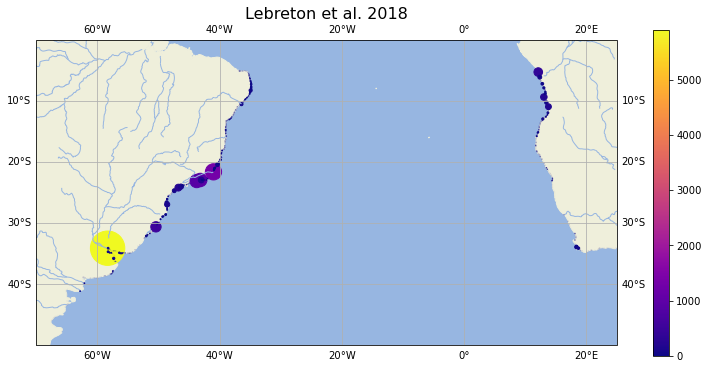

In [26]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

#plt.pcolormesh(X, Y, coast)
im = plt.scatter(bin_lebreton['X_bin'], bin_lebreton['Y_bin'], c=bin_lebreton['i_high'],
                 s=bin_lebreton['i_high']/5, cmap='plasma', edgecolors=None)
plt.colorbar(im)
plt.title('Lebreton et al. 2018', fontsize=16)

In [27]:
total_lebreton = bin_lebreton['i_high'].sum()

In [28]:
total_lebreton

13075.876366

Text(0.5, 1.0, 'Meijer al. 2021')

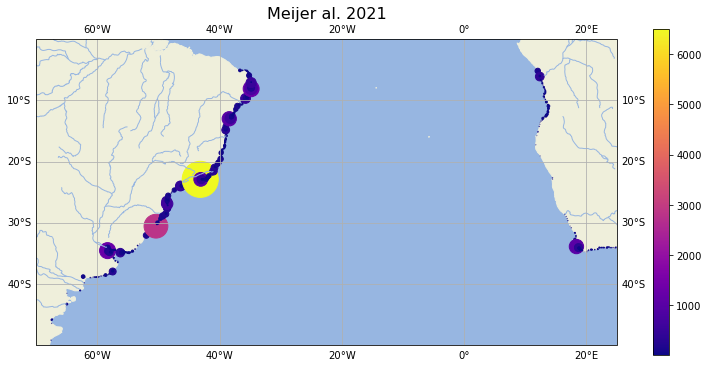

In [29]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

#plt.pcolormesh(X, Y, coast)
im = plt.scatter(bin_meijer['X_bin'], bin_meijer['Y_bin'], c=bin_meijer['dots_exten'],
                 s=bin_meijer['dots_exten']/5, cmap='plasma', edgecolors=None)
plt.colorbar(im)
plt.title('Meijer al. 2021', fontsize=16)

In [30]:
total_meijer = bin_meijer['dots_exten'].sum()

In [31]:
total_meijer

37539.313500000004

In [32]:
sort_meijer = bin_meijer.sort_values(['dots_exten'], ascending=False)
sort_meijer.reset_index(inplace=True, drop=True)

# How to do the clustering? 

Three words: center of mass.

In [33]:
cluster_locations = {'Congo':(-5.6442, 12.1375),
                     'Cape-Town':(-33.93, 18.56),
                    'Rio-de-la-Plata':(-33.9375, -58.5208),
                    'Porto-Alegre':(-30.051, -51.285),
                    'Santos':(-23.9875, -46.2958),
                    'Paraiba':(-21.6208, -41.0375),
                    'Itajai':(-26.9125, -48.6458),
                    'Rio-de-Janeiro':(-23.01250, -43.32083),
                    'Salvador':(-13.017065, -38.579832),
                    'Recife':(-8.09, -34.88)}
# 'Luanda':(-8.82, 13.22),
#                      'Cuvo':(-10.87917, 13.81250),
grid_cluster_centers = {}
for loc in cluster_locations:

    indx = nearest_coastal_cell(lat_coast, lon_coast, *cluster_locations[loc])
    grid_cluster_centers[loc] = (lat_coast[indx], lon_coast[indx])

In [34]:
grid_cluster_centers

{'Congo': (-5.6666665, 12.083333),
 'Cape-Town': (-33.916668, 18.416666),
 'Rio-de-la-Plata': (-34.083332, -58.333332),
 'Porto-Alegre': (-30.583334, -50.416668),
 'Santos': (-24.0, -46.333332),
 'Paraiba': (-21.583334, -41.0),
 'Itajai': (-26.916666, -48.583332),
 'Rio-de-Janeiro': (-23.0, -43.333332),
 'Salvador': (-13.083333, -38.583332),
 'Recife': (-8.083333, -34.833332)}

In [35]:
sort = bin_meijer.sort_values(['dots_exten'], ascending=False)
sort.reset_index(inplace=True, drop=True)

No handles with labels found to put in legend.


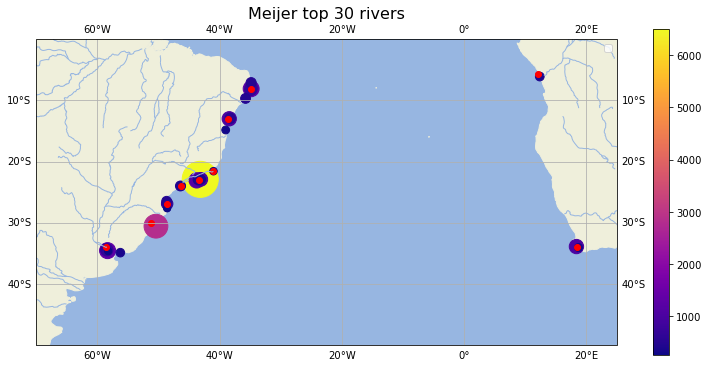

In [36]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

M = 30
#plt.pcolormesh(X, Y, coast)
im = plt.scatter(sort['X_bin'][:M], sort['Y_bin'][:M], c=sort['dots_exten'][:M],
                 s=sort['dots_exten'][:M]/5, cmap='plasma', edgecolors=None)

for loc in cluster_locations:
    x = cluster_locations[loc][1]
    y = cluster_locations[loc][0]
    plt.scatter(x, y, c='r')
    
plt.colorbar(im)
plt.title('Meijer top 30 rivers', fontsize=16)
plt.legend()

In [37]:
def center_of_mass(DF):
    
    x = DF.X_bin
    y = DF.Y_bin
    m = DF.dots_exten #this is so annoying
    M = m.sum()
    
    return sum(m*y)/M, sum(m*x)/M

In [53]:
def rivers_per_location(DF, loc_coords, radius, binned=False, tolerance=0.1):
    """
    It cluster the rivers in a square with sides 2*radius.
    The clustering is done iteratively using the center of mass.
    Input
    - DF: the pandas Dataframe with data River_sources. 
    - loc_coords: tuple with the location coordinates as in (lat, lon).
    - radius: the radius in degrees around loc_coords.
    - tolerance: [km]
    Returns 
    - the dataframe around loc_coords.
    """
    if binned:
        _label = '_bin'
        
    else:
        _label = ''
        
    x_col = f'X{_label}'
    y_col = f'Y{_label}'
    
    lat, lon = loc_coords
    mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & \
            (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
    CM = center_of_mass(DF[mask])
    dist = haversine_distance_two((lat,lon), CM)
    
    while dist > tolerance:
        lat, lon = CM
        mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & \
                (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
        CM = center_of_mass(DF[mask])
        dist = haversine_distance_two((lat,lon), CM)
    
    loc_df = DF[mask]
    p = pd.DataFrame({'p': loc_df['dots_exten']/loc_df['dots_exten'].sum()})
    loc_df = loc_df.drop(['dots_exten'], axis=1)
    loc_df = pd.concat([loc_df, p], axis=1)
    loc_df.reset_index(inplace=True)

    return mask, CM

In [54]:
_mask, _cm = rivers_per_location(sort, cluster_locations['Rio-de-Janeiro'], 1, binned=True)
print('CM', _cm)
print('OC', cluster_locations['Rio-de-Janeiro'])
print(haversine_distance_two(_cm, cluster_locations['Rio-de-Janeiro']))

CM (-22.945060155551054, -43.25007477878782)
OC (-23.0125, -43.32083)
10.419394448212095


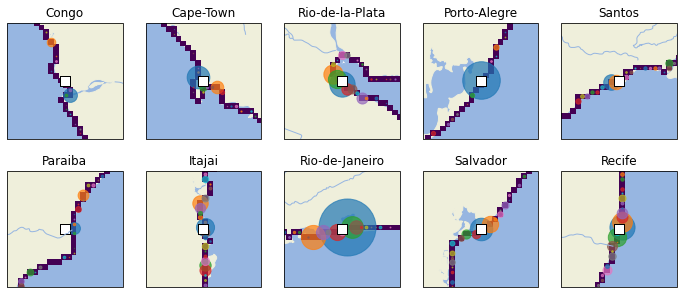

In [52]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(12,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

coast_mask = np.ma.masked_equal(coast, 0)

ax = np.reshape(ax, 10)
r = 1

for i, loc in enumerate(cluster_locations):
    
    loc_mask, loc_CM= rivers_per_location(sort, cluster_locations[loc], r, binned=True)
    lat_BA, lon_BA = loc_CM 
    loc_df = sort[loc_mask]
    
    ax[i].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.OCEAN)
    ax[i].add_feature(cfeature.LAND)
#     ax[i].add_feature(cfeature.COASTLINE)
    ax[i].add_feature(cfeature.RIVERS)
    ax[i].set_title(loc)
    ax[i].pcolormesh(X, Y, coast_mask)
#     g1 = ax[i].gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
#             color='black', linestyle='--', alpha=0.1)
#     g1.top_labels = False
#     g1.right_labels = False

    
    for m in loc_df.index:
        ax[i].scatter(loc_df['X_bin'][m], loc_df['Y_bin'][m], s=loc_df['dots_exten'][m]*0.5,
                     alpha=0.7)
#         ax[i].scatter(cluster_locations[loc][1], cluster_locations[loc][0], c='white',
#                       marker='s',  edgecolor='k', s=100)
        ax[i].scatter(loc_CM[1], loc_CM[0], c='white', marker='s', edgecolor='k', s=100)
    

In [163]:
def compute_clusters(DF, N, cluster_radius=1, compute_other=False):
    
    release_points = {}
    priors = {}

    cluster_percent = 0
    merged_rivers = 0

    for i, loc in enumerate(cluster_locations):
        print(loc)
        _mask, _CM = rivers_per_location(sort, cluster_locations[loc], cluster_radius, binned=True)
        lat_BA, lon_BA = _CM 
        loc_df = sort[_mask]

        loc_percent = loc_df['dots_exten'].sum()/total_meijer
        no_rivers = loc_df['merged_rivers'].sum()
        merged_rivers += no_rivers
        priors[loc] = [loc_percent, no_rivers]
        cluster_percent += loc_df['dots_exten'].sum()/total_meijer
        p = pd.DataFrame({'p': loc_df['dots_exten']/loc_df['dots_exten'].sum()})

        loc_df = loc_df.drop(['dots_exten'], axis=1)
        loc_df = pd.concat([loc_df, p], axis=1)
        loc_df.reset_index(drop=True, inplace=True)

        release_points[loc] = loc_df.sample(n=N, replace=True, weights='p')

    if compute_other:
        priors['Other'] = [1 - cluster_percent, sa_meijer.shape[0] - merged_rivers]
        priors = pd.DataFrame(priors).T

    priors = priors.rename(columns={0:'mean', 1:'merged_rivers'})
    
    return release_points, priors

In [197]:

release_points = {}
priors = {}
r = 1
N = 100000 #Number of particles realesed pre source.

cluster_percent = 0
merged_rivers = 0

for i, loc in enumerate(cluster_locations):
    print(loc)
    _mask, _CM = rivers_per_location(sort, cluster_locations[loc], r, binned=True)
    lat_BA, lon_BA = _CM 
    loc_df = sort[_mask]
    
    loc_percent = loc_df['dots_exten'].sum()/total_meijer
    no_rivers = loc_df['merged_rivers'].sum()
    merged_rivers += no_rivers
    priors[loc] = [loc_percent, no_rivers]
    cluster_percent += loc_df['dots_exten'].sum()/total_meijer
    p = pd.DataFrame({'p': loc_df['dots_exten']/loc_df['dots_exten'].sum()})
    
    loc_df = loc_df.drop(['dots_exten'], axis=1)
    loc_df = pd.concat([loc_df, p], axis=1)
    loc_df.reset_index(drop=True, inplace=True)

    release_points[loc] = loc_df.sample(n=N, replace=True, weights='p')
    
priors['Other'] = [1 - cluster_percent, sa_meijer.shape[0] - merged_rivers]
priors = pd.DataFrame(priors).T
priors = priors.rename(columns={0:'mean', 1:'merged_rivers'})
priors.to_csv('../data/analysis/river_input_analysis.csv')

Congo
Cape-Town
Rio-de-la-Plata
Porto-Alegre
Santos
Paraiba
Itajai
Rio-de-Janeiro
Salvador
Recife


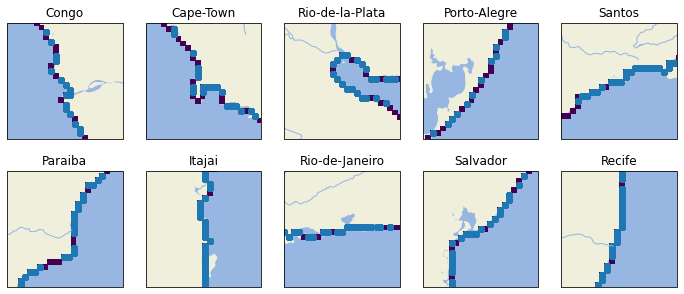

In [107]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(12,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

coast_mask = np.ma.masked_equal(coast, 0)

ax = np.reshape(ax, 10)
r = 1

for i, loc in enumerate(cluster_locations):
    
    loc_mask, loc_CM= rivers_per_location(sort, cluster_locations[loc], r, binned=True)
    lat_BA, lon_BA = loc_CM 
#     loc_df = sort[loc_mask]
    
    ax[i].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.OCEAN)
    ax[i].add_feature(cfeature.LAND)
    ax[i].add_feature(cfeature.RIVERS)
    ax[i].set_title(loc)
    ax[i].pcolormesh(X, Y, coast_mask)
    ax[i].scatter(release_points[loc]['X_bin'], release_points[loc]['Y_bin'])


array([[<AxesSubplot:title={'center':'X_bin'}>]], dtype=object)

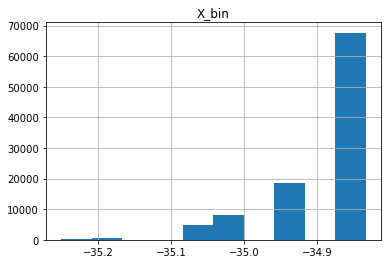

In [134]:
release_points['Recife'].hist('X_bin')

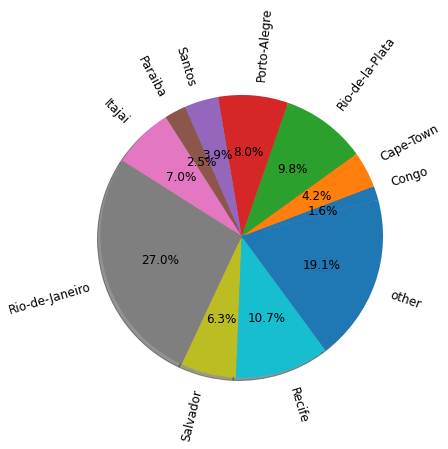

In [48]:
plt.figure(figsize=(7,6.5))
wedgeprops = {'fontsize': 12}

plt.pie(priors['mean'], labels=priors.index, autopct='%.1f%%',
       shadow=True,
       rotatelabels=True, startangle=15,textprops=wedgeprops);
